In [3]:
import sys, os
sys.path.insert(0, os.path.abspath('../python'))
import decord as de

In [4]:
ctx = de.cpu(0)
# using batchsize = 2 and smaller resolution in this example
shape = (2, 480, 640, 3)
# using kinetics example videos
videos = ['flipping_a_pancake.mkv']
# using in-batch frame interval 5
interval = 20
# using inter-batch frame interval 20, which means batch-batch interval is 20
skip = 50

In [6]:
vl = de.VideoLoader(videos, ctx=ctx, shape=shape, interval=interval, skip=skip, shuffle=0)
print('num batches:', len(vl))

num batches: 4


batch data shape: (2, 480, 640, 3)
indices: (file: 0 frame: 0), (file: 0 frame: 21)
----------
batch data shape: (2, 480, 640, 3)
indices: (file: 0 frame: 72), (file: 0 frame: 93)
----------
batch data shape: (2, 480, 640, 3)
indices: (file: 0 frame: 144), (file: 0 frame: 165)
----------
batch data shape: (2, 480, 640, 3)
indices: (file: 0 frame: 216), (file: 0 frame: 237)
----------


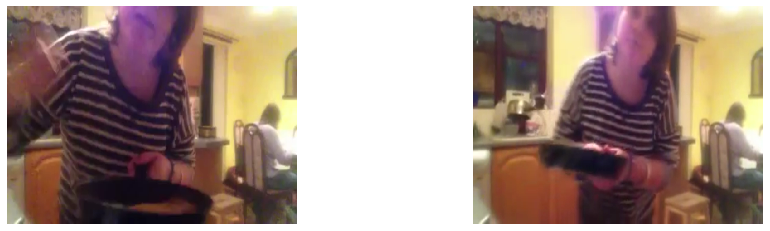

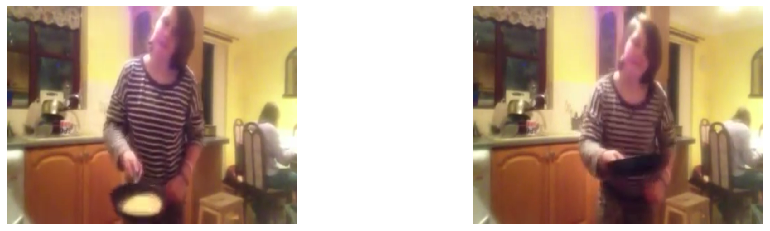

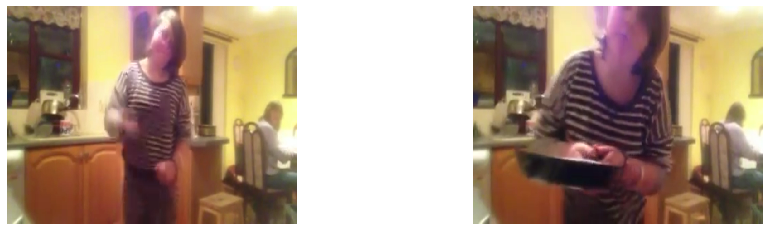

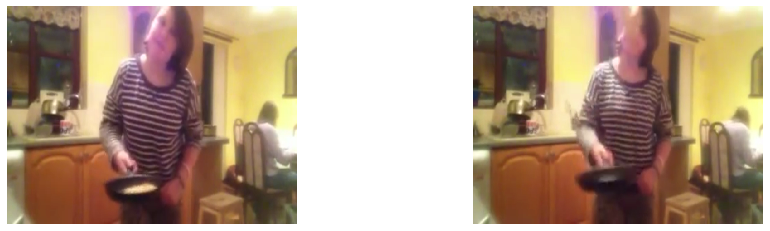

In [7]:
def disp_batches(video_loader, max_disp=5):
    %matplotlib inline
    from matplotlib import pyplot as plt
    import matplotlib.gridspec as gridspec
    cnt = 0
    vl.reset()
    for batch in vl:
        if cnt >= max_disp:
            break
        print('batch data shape:', batch[0].shape)
        print('indices:', ', '.join(['(file: {} frame: {})'.format(x, y) for x, y in batch[1].asnumpy()]))
        print('----------')
        data = batch[0].asnumpy()
        columns = 4
        rows = max(1, (data.shape[0] + 1) // columns)
        fig = plt.figure(figsize = (32,(16 // columns) * rows))
        gs = gridspec.GridSpec(rows, columns)
        for i in range(data.shape[0]):
            plt.subplot(gs[i])
            plt.axis("off")
            plt.imshow(data[i])
        cnt += 1
disp_batches(vl, 5)

In [2]:
import cv2  # still used to save images out
import os
import numpy as np
from decord import VideoReader
from decord import cpu, gpu


def extract_frames(video_path, frames_dir, overwrite=False, start=-1, end=-1, every=1):
    """
    Extract frames from a video using decord's VideoReader
    :param video_path: path of the video
    :param frames_dir: the directory to save the frames
    :param overwrite: to overwrite frames that already exist?
    :param start: start frame
    :param end: end frame
    :param every: frame spacing
    :return: count of images saved
    """

    video_path = os.path.normpath(video_path)  # make the paths OS (Windows) compatible
    frames_dir = os.path.normpath(frames_dir)  # make the paths OS (Windows) compatible

    video_dir, video_filename = os.path.split(video_path)  # get the video path and filename from the path

    assert os.path.exists(video_path)  # assert the video file exists

    # load the VideoReader
    vr = VideoReader(video_path, ctx=cpu(0))  # can set to cpu or gpu .. ctx=gpu(0)
                     
    if start < 0:  # if start isn't specified lets assume 0
        start = 0
    if end < 0:  # if end isn't specified assume the end of the video
        end = len(vr)

    frames_list = list(range(start, end, every))
    saved_count = 0

    if every > 25 and len(frames_list) < 1000:  # this is faster for every > 25 frames and can fit in memory
        frames = vr.get_batch(frames_list).asnumpy()

        for index, frame in zip(frames_list, frames):  # lets loop through the frames until the end
            save_path = os.path.join(frames_dir, video_filename, "{:010d}.jpg".format(index))  # create the save path
            if not os.path.exists(save_path) or overwrite:  # if it doesn't exist or we want to overwrite anyways
                cv2.imwrite(save_path, cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # save the extracted image
                saved_count += 1  # increment our counter by one

    else:  # this is faster for every <25 and consumes small memory
        for index in range(start, end):  # lets loop through the frames until the end
            frame = vr[index]  # read an image from the capture
            
            if index % every == 0:  # if this is a frame we want to write out based on the 'every' argument
                save_path = os.path.join(frames_dir, "{:010d}.jpg".format(index))  # create the save path
                if not os.path.exists(save_path) or overwrite:  # if it doesn't exist or we want to overwrite anyways
                    cv2.imwrite(save_path, cv2.cvtColor(frame.asnumpy(), cv2.COLOR_RGB2BGR))  # save the extracted image
                    saved_count += 1  # increment our counter by one

    return saved_count  # and return the count of the images we saved


def video_to_frames(video_path, frames_dir, overwrite=False, every=1):
    """
    Extracts the frames from a video
    :param video_path: path to the video
    :param frames_dir: directory to save the frames
    :param overwrite: overwrite frames if they exist?
    :param every: extract every this many frames
    :return: path to the directory where the frames were saved, or None if fails
    """

    video_path = os.path.normpath(video_path)  # make the paths OS (Windows) compatible
    frames_dir = os.path.normpath(frames_dir)  # make the paths OS (Windows) compatible

    video_dir, video_filename = os.path.split(video_path)  # get the video path and filename from the path

    # make directory to save frames, its a sub dir in the frames_dir with the video name
    os.makedirs(os.path.join(frames_dir, video_filename), exist_ok=True)
    
    print("Extracting frames from {}".format(video_filename))
    
    extract_frames(video_path, frames_dir, every=every)  # let's now extract the frames

    return os.path.join(frames_dir, video_filename)  # when done return the directory containing the frames


video_to_frames(video_path='flipping_a_pancake.mkv', frames_dir='test_frames', overwrite=False, every=5)

Extracting frames from flipping_a_pancake.mkv


'test_frames/flipping_a_pancake.mkv'

In [34]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import cv2
import multiprocessing
import os
import sys


def print_progress(iteration, total, prefix='', suffix='', decimals=3, bar_length=100):
    """
    Call in a loop to create standard out progress bar

    :param iteration: current iteration
    :param total: total iterations
    :param prefix: prefix string
    :param suffix: suffix string
    :param decimals: positive number of decimals in percent complete
    :param bar_length: character length of bar
    :return: None
    """

    format_str = "{0:." + str(decimals) + "f}"  # format the % done number string
    percents = format_str.format(100 * (iteration / float(total)))  # calculate the % done
    filled_length = int(round(bar_length * iteration / float(total)))  # calculate the filled bar length
    bar = '#' * filled_length + '-' * (bar_length - filled_length)  # generate the bar string
    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percents, '%', suffix)),  # write out the bar
    sys.stdout.flush()  # flush to stdout


def extract_frames(video_path, frames_dir, overwrite=False, start=-1, end=-1, every=1):
    """
    Extract frames from a video using OpenCVs VideoCapture

    :param video_path: path of the video
    :param frames_dir: the directory to save the frames
    :param overwrite: to overwrite frames that already exist?
    :param start: start frame
    :param end: end frame
    :param every: frame spacing
    :return: count of images saved
    """

    video_path = os.path.normpath(video_path)  # make the paths OS (Windows) compatible
    frames_dir = os.path.normpath(frames_dir)  # make the paths OS (Windows) compatible

    video_dir, video_filename = os.path.split(video_path)  # get the video path and filename from the path

    assert os.path.exists(video_path)  # assert the video file exists

    capture = cv2.VideoCapture(video_path)  # open the video using OpenCV

    if start < 0:  # if start isn't specified lets assume 0
        start = 0
    if end < 0:  # if end isn't specified assume the end of the video
        end = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

    capture.set(1, start)  # set the starting frame of the capture
    frame = start  # keep track of which frame we are up to, starting from start
    while_safety = 0  # a safety counter to ensure we don't enter an infinite while loop (hopefully we won't need it)
    saved_count = 0  # a count of how many frames we have saved

    while frame < end:  # lets loop through the frames until the end

        _, image = capture.read()  # read an image from the capture

        if while_safety > 500:  # break the while if our safety maxs out at 500
            break

        # sometimes OpenCV reads None's during a video, in which case we want to just skip
        if image is None:  # if we get a bad return flag or the image we read is None, lets not save
            while_safety += 1  # add 1 to our while safety, since we skip before incrementing our frame variable
            continue  # skip

        if frame % every == 0:  # if this is a frame we want to write out based on the 'every' argument
            while_safety = 0  # reset the safety count
            save_path = os.path.join(frames_dir, video_filename, "{:010d}.jpg".format(frame))  # create the save path
            if not os.path.exists(save_path) or overwrite:  # if it doesn't exist or we want to overwrite anyways
                cv2.imwrite(save_path, image)  # save the extracted image
                saved_count += 1  # increment our counter by one

        frame += 1  # increment our frame count

    capture.release()  # after the while has finished close the capture

    return saved_count  # and return the count of the images we saved


def video_to_frames(video_path, frames_dir, overwrite=False, every=1, chunk_size=1000):
    """
    Extracts the frames from a video using multiprocessing

    :param video_path: path to the video
    :param frames_dir: directory to save the frames
    :param overwrite: overwrite frames if they exist?
    :param every: extract every this many frames
    :param chunk_size: how many frames to split into chunks (one chunk per cpu core process)
    :return: path to the directory where the frames were saved, or None if fails
    """

    video_path = os.path.normpath(video_path)  # make the paths OS (Windows) compatible
    frames_dir = os.path.normpath(frames_dir)  # make the paths OS (Windows) compatible

    video_dir, video_filename = os.path.split(video_path)  # get the video path and filename from the path

    # make directory to save frames, its a sub dir in the frames_dir with the video name
    os.makedirs(os.path.join(frames_dir, video_filename), exist_ok=True)

    capture = cv2.VideoCapture(video_path)  # load the video
    total = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))  # get its total frame count
    capture.release()  # release the capture straight away

    if total < 1:  # if video has no frames, might be and opencv error
        print("Video has no frames. Check your OpenCV + ffmpeg installation")
        return None  # return None

    frame_chunks = [[i, i+chunk_size] for i in range(0, total, chunk_size)]  # split the frames into chunk lists
    frame_chunks[-1][-1] = min(frame_chunks[-1][-1], total-1)  # make sure last chunk has correct end frame, also handles case chunk_size < total

    prefix_str = "Extracting frames from {}".format(video_filename)  # a prefix string to be printed in progress bar

    # execute across multiple cpu cores to speed up processing, get the count automatically
    with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:

        futures = [executor.submit(extract_frames, video_path, frames_dir, overwrite, f[0], f[1], every)
                   for f in frame_chunks]  # submit the processes: extract_frames(...)

        """for i, f in enumerate(as_completed(futures)):  # as each process completes
            print_progress(i, len(frame_chunks)-1, prefix=prefix_str, suffix='Complete')  # print it's progress"""

    return os.path.join(frames_dir, video_filename)  # when done return the directory containing the frames


if __name__ == '__main__':
    # test it
    video_to_frames(video_path='test.mp4', frames_dir='test_frames', overwrite=False, every=5, chunk_size=1000)

Video has no frames. Check your OpenCV + ffmpeg installation





100%|██████████| 364/364 [00:00<00:00, 404538.06it/s]



100%|██████████| 364/364 [00:00<00:00, 295190.77it/s]



100%|██████████| 364/364 [00:00<00:00, 810794.83it/s]



100%|██████████| 364/364 [00:00<00:00, 315700.30it/s]using decord
Video has no frames. Check your OpenCV + ffmpeg installation
using decord
Video has no frames. Check your OpenCV + ffmpeg installation
using decord
Video has no frames. Check your OpenCV + ffmpeg installation
using decord
Video has no frames. Check your OpenCV + ffmpeg installation



In [1]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import cv2
import multiprocessing
import os
import sys


def print_progress(iteration, total, prefix='', suffix='', decimals=3, bar_length=100):
    """
    Call in a loop to create standard out progress bar

    :param iteration: current iteration
    :param total: total iterations
    :param prefix: prefix string
    :param suffix: suffix string
    :param decimals: positive number of decimals in percent complete
    :param bar_length: character length of bar
    :return: None
    """

    format_str = "{0:." + str(decimals) + "f}"  # format the % done number string
    percents = format_str.format(100 * (iteration / float(total)))  # calculate the % done
    filled_length = int(round(bar_length * iteration / float(total)))  # calculate the filled bar length
    bar = '#' * filled_length + '-' * (bar_length - filled_length)  # generate the bar string
    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percents, '%', suffix)),  # write out the bar
    sys.stdout.flush()  # flush to stdout


def extract_frames(video_path, frames_dir, overwrite=False, start=-1, end=-1, every=1):
    """
    Extract frames from a video using OpenCVs VideoCapture

    :param video_path: path of the video
    :param frames_dir: the directory to save the frames
    :param overwrite: to overwrite frames that already exist?
    :param start: start frame
    :param end: end frame
    :param every: frame spacing
    :return: count of images saved
    """

    video_path = os.path.normpath(video_path)  # make the paths OS (Windows) compatible
    frames_dir = os.path.normpath(frames_dir)  # make the paths OS (Windows) compatible

    video_dir, video_filename = os.path.split(video_path)  # get the video path and filename from the path

    assert os.path.exists(video_path)  # assert the video file exists

    capture = cv2.VideoCapture(video_path)  # open the video using OpenCV

    if start < 0:  # if start isn't specified lets assume 0
        start = 0
    if end < 0:  # if end isn't specified assume the end of the video
        end = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

    capture.set(1, start)  # set the starting frame of the capture
    frame = start  # keep track of which frame we are up to, starting from start
    while_safety = 0  # a safety counter to ensure we don't enter an infinite while loop (hopefully we won't need it)
    saved_count = 0  # a count of how many frames we have saved

    while frame < end:  # lets loop through the frames until the end

        _, image = capture.read()  # read an image from the capture

        if while_safety > 500:  # break the while if our safety maxs out at 500
            break

        # sometimes OpenCV reads None's during a video, in which case we want to just skip
        if image is None:  # if we get a bad return flag or the image we read is None, lets not save
            while_safety += 1  # add 1 to our while safety, since we skip before incrementing our frame variable
            continue  # skip

        if frame % every == 0:  # if this is a frame we want to write out based on the 'every' argument
            while_safety = 0  # reset the safety count
            save_path = os.path.join(frames_dir, "{:010d}.jpg".format(frame))  # create the save path
            if not os.path.exists(save_path) or overwrite:  # if it doesn't exist or we want to overwrite anyways
                cv2.imwrite(save_path, image)  # save the extracted image
                saved_count += 1  # increment our counter by one

        frame += 1  # increment our frame count

    capture.release()  # after the while has finished close the capture

    return saved_count  # and return the count of the images we saved


def video_to_frames(video_path, frames_dir, overwrite=True, every=1, chunk_size=1000):
    """
    Extracts the frames from a video using multiprocessing

    :param video_path: path to the video
    :param frames_dir: directory to save the frames
    :param overwrite: overwrite frames if they exist?
    :param every: extract every this many frames
    :param chunk_size: how many frames to split into chunks (one chunk per cpu core process)
    :return: path to the directory where the frames were saved, or None if fails
    """

    video_path = os.path.normpath(video_path)  # make the paths OS (Windows) compatible
    frames_dir = os.path.normpath(frames_dir)  # make the paths OS (Windows) compatible

    video_dir, video_filename = os.path.split(video_path)  # get the video path and filename from the path

    # make directory to save frames, its a sub dir in the frames_dir with the video name
    os.makedirs(os.path.join(frames_dir, video_filename), exist_ok=True)

    capture = cv2.VideoCapture(video_path)  # load the video
    total = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))  # get its total frame count
    capture.release()  # release the capture straight away

    if total < 1:  # if video has no frames, might be and opencv error
        print("Video has no frames. Check your OpenCV + ffmpeg installation")
        return None  # return None

    frame_chunks = [[i, i+chunk_size] for i in range(0, total, chunk_size)]  # split the frames into chunk lists
    frame_chunks[-1][-1] = min(frame_chunks[-1][-1], total-1)  # make sure last chunk has correct end frame, also handles case chunk_size < total

    prefix_str = "Extracting frames from {}".format(video_filename)  # a prefix string to be printed in progress bar

    # execute across multiple cpu cores to speed up processing, get the count automatically
    with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:

        futures = [executor.submit(extract_frames, video_path, frames_dir, overwrite, f[0], f[1], every)
                   for f in frame_chunks]  
    return os.path.join(frames_dir, video_filename)  # when done return the directory containing the frames


for dataset in DATASET_PATHS.keys():
    videos_path = join(data_path, DATASET_PATHS['Deepfakes'], 'c40', 'videos')
    images_path = join(data_path, DATASET_PATHS['Deepfakes'], 'c40', 'images')
    for video in tqdm(os.listdir(videos_path)):
        image_folder = video.split('.')[0]
        video_to_frames(video_path= join(videos_path, video), frames_dir= join(images_path, image_folder), overwrite=False, every=5, chunk_size=1000)

NameError: name 'DATASET_PATHS' is not defined

In [ ]:
"""        video_to_frames(video_path= join(videos_path, video), frames_dir=join(images_path, image_folder), overwrite=False, every=5, chunk_size=1000)"""